For running first time on your computer, make sure you have following packages installed. In case you have new qiskit on the machine, please be careful while installing these old versions. It is suggested to install the following packages and run the codes in isolated environment. 

!pip install qiskit-aer

!pip install qutip


In [1]:
from decomposition import *        #matrix decomposition into elementary gates

#IBM qiskit packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister           
from qiskit_aer import Aer
# from qiskit.visualization import plot_histogram, plot_state_city

from qutip import *             #qutip package

#These are standard Python packages
import scipy.linalg as la       #linear algebra
import numpy as np              #matrix and math functions
import csv                      #file format management
import time                     #timers
import pdb                      #debug tool

In [2]:
start_time = time.time()

hb = 6.5821195e-16  # in eV*s
N=5
K=8
ti2 = 2000#time step
step=400
err=0.01
err2=0.001
q = QuantumRegister(6)
c = ClassicalRegister(6)

#rate constants
ga = np.zeros(K)
# ga[1] = 2*3e-3*1e15
# ga[2] = 2*3e-3*1e15
# ga[3] = 2*3e-3*1e15
# ga[4] = 2*5e-7*1e15
# ga[5] = 2*5e-7*1e15
# ga[6] = 2*5e-7*1e15
# ga[7] = 2*6.28e-3*1e15
ga[1] = 2*0.0000725665297951499
ga[2] = 2*0.0000725665297951499
ga[3] = 2*0.0000725665297951499
ga[4] = 2*1.20944216325250E-8
ga[5] = 2*1.20944216325250E-8
ga[6] = 2*1.20944216325250E-8
ga[7] = 2*0.000151978502234310

In [3]:

#matrices used later
rho = np.zeros((N,N),"complex")
rhosum = np.zeros((N,N),"complex")
M = np.zeros((K,N,N),"complex")
Mini = np.zeros((K,N,N),"complex")
eigMini = np.zeros((K,N,N),"complex")

#matrix lists used later
BM = np.zeros((K,N,N),"complex")    
CM = np.zeros((K,N,N),"complex")
DM = np.zeros((K,N*2,N*2),"complex")    #This is the dilated matrix list
eigM = np.zeros((K,N,N),"complex")

#more matrices
Msum = np.zeros((N,N),"complex")
HamilM = np.zeros((N,N),"complex")
U = np.zeros((N,N),"complex")
eigCoM = np.zeros((N,N),"complex")
CoM = np.zeros((N,N),"complex")

#These types are used for redundant matrix simplification, can be implemented with one representative matrix for each.
type4 = np.zeros((N,N),"complex")
type5 = np.zeros((N,N),"complex")
type6 = np.zeros((N,N),"complex")
type7 = np.zeros((N,N),"complex")         
type10 = np.zeros((N,N),"complex")
type11 = np.zeros((N,N),"complex")

type4[0,1] = 1.0
type5[0,2] = 1.0
type6[0,3] = 1.0        
type7[4,3] = 1.0
type10[4,1] = 1.0
type11[4,2] = 1.0

#Kraus matrix lists for the 2nd-6th iterations
matrixM2 = np.zeros((K,K,N,N),"complex")
matrixM3 = np.zeros((K,K,K,N,N),"complex")
matrixM4 = np.zeros((K,K,K,K,N,N),"complex")
matrixM5 = np.zeros((K,K,K,K,K,N,N),"complex")
matrixM6 = np.zeros((K,K,K,K,K,K,N,N),"complex")

#Hamiltonian definition
# HamilM[1,1] = 0.0267
# HamilM[1,2] = -0.0129
# HamilM[1,3] = 0.000632
# HamilM[2,1] = -0.0129
# HamilM[2,2] = 0.0273
# HamilM[2,3] = 0.00404
# HamilM[3,1] = 0.000632
# HamilM[3,2] = 0.00404

HamilM[1,1] = 0.000979612027522062
HamilM[1,2] = -0.000474314474721147
HamilM[1,3] = 0.0000232373085598257
HamilM[2,1] = -0.000474314474721147
HamilM[2,2] = 0.00100239370258071
HamilM[2,3] = 0.000148536521382415
HamilM[3,1] = 0.0000232373085598257
HamilM[3,2] = 0.000148536521382415
# HamilM=(2*np.pi*HamilM/(4.135e-15))
# print(HamilM)


In [4]:
Hamil = Qobj(HamilM)

eigvals = Hamil.eigenenergies() 
eigvecs = Hamil.eigenstates()[1]


for j in range(N):
	U[j,0] = eigvecs[1][j][0]
	U[j,4] = eigvecs[2][j][0]
	U[j,1] = eigvecs[0][j][0]
	U[j,2] = eigvecs[3][j][0]
	U[j,3] = eigvecs[4][j][0]


#definition of various forms of the initial state
M0test= np.zeros((N,N),"complex")

v0 = np.zeros((N,1))
v0[1,0]=1

v1_ini = np.zeros((N*2,1),"complex")  #For this example there is only one initial state for the physical composition of the density matrix
v1_ini[1,0]=1
v1 = np.zeros((N*2,1))

vsum = np.zeros((N*2,1), "complex")

vpop = np.zeros((N,1))
vpop[1,0]=1

rho_ini =v0.dot(v0.conj().T)
rho =v0.dot(v0.conj().T)


In [5]:
# def addunitary(um,cirq,qr):
#     d = um.shape[0]
#     if not np.log2(d).is_integer():
#         n = int(np.ceil(np.log2(d)))
#         # pad = 2**n - d
#         new_U = np.eye(2**n, dtype=complex)
#         # new_U[pad:,pad:] = U
#         new_U[:d,:d] = um
#         um = new_U

#     return cirq.unitary(um,qr)

In [6]:
rho0 = []
rho1 = []
rho2 = []
rho3 = []
rhos = []

for t in range(1,6):
	#initial state populations
	rho0.append(np.real(v1_ini[0,0].conj()*v1_ini[0,0]))
	rho1.append(np.real(v1_ini[1,0].conj()*v1_ini[1,0]))
	rho2.append(np.real(v1_ini[2,0].conj()*v1_ini[2,0]))
	rho3.append(np.real(v1_ini[3,0].conj()*v1_ini[3,0]))
	rhos.append(np.real(v1_ini[4,0].conj()*v1_ini[4,0]))
	
	#1st iteration
	ti = t*step
	for i in range(K):
		Mini[i]=Mini[i]*0
	
	#generating Kraus matrices for the 1st iteration
	Mini[1][1,1] = np.sqrt(ga[1]*ti)
	Mini[2][2,2] = np.sqrt(ga[2]*ti)
	Mini[3][3,3] = np.sqrt(ga[3]*ti)
	Mini[4][0,1] = np.sqrt(ga[4]*ti)
	Mini[5][0,2] = np.sqrt(ga[5]*ti)
	Mini[6][0,3] = np.sqrt(ga[6]*ti)
	Mini[7][4,3] = np.sqrt(ga[7]*ti)

	Msum=Msum*0
	for i in range(1,K):
		Msum += (Mini[i].conj().T).dot(Mini[i])
		
	Mini[0] = np.sqrt(np.identity(N)-Msum)  #This is the M0 from the Kraus formulation

	for i in range(K):
		eigMini[i] = (U.conj().T).dot(Mini[i]).dot(U)

	eigCoM[0][0]= 1
	eigCoM[1][1]= np.exp(-1j*eigvals[0]*ti)
	eigCoM[2][2]= np.exp(-1j*eigvals[3]*ti)
	eigCoM[3][3]= np.exp(-1j*eigvals[4]*ti)
	eigCoM[4][4]= 1

	CoM = U.dot(eigCoM).dot(U.conj().T)
		
	#calculating dilated matrices for the 1st iteration
	for i in range(K):
		Mini[i]=CoM.dot(Mini[i])
		BM[i] = la.sqrtm(np.identity(N)-(Mini[i].conj().T).dot(Mini[i]))
		CM[i] = la.sqrtm(np.identity(N)-Mini[i].dot(Mini[i].conj().T))
		tempM1 = np.concatenate((Mini[i],BM[i]))
		tempM2 = np.concatenate((CM[i],-Mini[i].conj().T))
		DM[i] = np.concatenate((tempM1,tempM2),axis=1)
	
	

	circ1=[]
	result1=[]
	count1=[]
	pop0 = 0
	pop1 = 0
	pop2 = 0
	pop3 = 0
	pops = 0

	
	for i in range(K):
		#generating quantum circuits
		circ_ini = QuantumCircuit(q,c)
		circ_ini.x(0)
		# print(DM[i].dot(DM[i].conj().T))
		circ1.append(general_implement(DM[i],circ_ini,q))
		# add_circ=addunitary(DM[i],circ_ini,q)
		# circ1.append(add_circ)
		circ1[i].measure(q,c)
		
		simulator = Aer.get_backend('qasm_simulator')
		
		#execute quantum circuits and get measurement results
		result1.append(simulator.run(circ1[i]).result())
		count1.append(result1[i].get_counts(circ1[i]))
		
		#process results into populations
		pop0+=count1[i].get('000000',0)/1024
		pop1+=count1[i].get('000001',0)/1024
		pop2+=count1[i].get('000010',0)/1024
		pop3+=count1[i].get('000011',0)/1024
		pops+=count1[i].get('000100',0)/1024
			
	rho0.append(pop0)
	rho1.append(pop1)
	rho2.append(pop2)
	rho3.append(pop3)
	rhos.append(pops)
		


	ti = ti2
	for i in range(K):
		M[i]=M[i]*0
	
	M[1][1,1] = np.sqrt(ga[1]*ti)
	M[2][2,2] = np.sqrt(ga[2]*ti)
	M[3][3,3] = np.sqrt(ga[3]*ti)
	M[4][0,1] = np.sqrt(ga[4]*ti)
	M[5][0,2] = np.sqrt(ga[5]*ti)
	M[6][0,3] = np.sqrt(ga[6]*ti)
	M[7][4,3] = np.sqrt(ga[7]*ti)

	Msum=Msum*0
	for i in range(1,K):
		Msum += (M[i].conj().T).dot(M[i])
		
	M[0] = np.sqrt(np.identity(N)-Msum)  

	M0test = np.identity(N)-(0.5*Msum)     

	for i in range(K):
		eigM[i] = (U.conj().T).dot(M[i]).dot(U)

	eigCoM[0][0]= 1
	eigCoM[1][1]= np.exp(-1j*eigvals[0]*ti)
	eigCoM[2][2]= np.exp(-1j*eigvals[3]*ti)
	eigCoM[3][3]= np.exp(-1j*eigvals[4]*ti)
	eigCoM[4][4]= 1

	CoM = U.dot(eigCoM).dot(U.conj().T)
	for i in range(K):
		M[i]=CoM.dot(M[i])

	#2nd iteration

	type0=[]
	type1=[]
	type2=[]
	type3=[]              #These types are implemented as lists.
	type8=[]
	type9=[]

	vsum = vsum*0
	rhosum = rhosum*0
	count2=0
	C0=0
	C1=0
	C2=0
	C3=0
	C4=[]
	C5=[]
	C6=[]
	C7=[]
	C8=0
	C9=0
	C10=[]
	C11=[]
	
	#generating the Kraus matrix lists for the 2nd iteration
	for i in range(K):
		for j in range(K):
			matrixM2[i][j] = M[i].dot(Mini[j])
			if np.linalg.norm(matrixM2[i][j],ord=2 )> err:
				
				if ( abs(matrixM2[i,j][1,1]) > err2 and abs(matrixM2[i,j][1,2]) > err2 and
					 abs(matrixM2[i,j][1,3]) > err2 and abs(matrixM2[i,j][2,1]) > err2 and
					 abs(matrixM2[i,j][2,2]) > err2 and abs(matrixM2[i,j][2,3]) > err2 and
					 abs(matrixM2[i,j][3,1]) > err2 and abs(matrixM2[i,j][3,2]) > err2 and
					 abs(matrixM2[i,j][3,3]) > err2 ):
					
					C0+=1
					type0.append(matrixM2[i,j])
					count2+=1
				
				elif ( abs(matrixM2[i,j][1,1]) > err2 and abs(matrixM2[i,j][2,1]) > err2 and
					 abs(matrixM2[i,j][3,1]) > err2 ):
					
					C1+=1
					type1.append(matrixM2[i,j])
					count2+=1
				
				elif ( abs(matrixM2[i,j][1,2]) > err2 and abs(matrixM2[i,j][2,2]) > err2 and
					 abs(matrixM2[i,j][3,2]) > err2 ):
					
					C2+=1
					type2.append(matrixM2[i,j])
					count2+=1
					
				elif ( abs(matrixM2[i,j][1,3]) > err2 and abs(matrixM2[i,j][2,3]) > err2 and
					 abs(matrixM2[i,j][3,3]) > err2 ):
					
					C3+=1
					type3.append(matrixM2[i,j])
					count2+=1
				
				
				if ( abs(matrixM2[i,j][0,1]) > err2 and abs(matrixM2[i,j][0,2]) > err2 and
					 abs(matrixM2[i,j][0,3]) > err2 ):
					
					C8+=1
					type8.append(matrixM2[i,j])
					count2+=1
				
				#Note below the coefficients are already squared!!
				elif abs(matrixM2[i,j][0,1]) > err2:
					C4.append(abs(matrixM2[i,j][0,1])*abs(matrixM2[i,j][0,1]))
					
					count2+=1
					
				elif abs(matrixM2[i,j][0,2]) > err2:
					C5.append(abs(matrixM2[i,j][0,2])*abs(matrixM2[i,j][0,2]))
					
					count2+=1
				
				elif abs(matrixM2[i,j][0,3]) > err2:
					C6.append(abs(matrixM2[i,j][0,3])*abs(matrixM2[i,j][0,3]))
					
					count2+=1
				
				
				if ( abs(matrixM2[i,j][4,1]) > err2 and abs(matrixM2[i,j][4,2]) > err2 and
					 abs(matrixM2[i,j][4,3]) > err2 ):
					
					C9+=1
					type9.append(matrixM2[i,j])
					count2+=1
				
				elif abs(matrixM2[i,j][4,3]) > err2:
					C7.append(abs(matrixM2[i,j][4,3])*abs(matrixM2[i,j][4,3]))
					
					count2+=1
					
				elif abs(matrixM2[i,j][4,1]) > err2:
					C10.append(abs(matrixM2[i,j][4,1])*abs(matrixM2[i,j][4,1]))
					
					count2+=1
				
				elif abs(matrixM2[i,j][4,2]) > err2:
					C11.append(abs(matrixM2[i,j][4,2])*abs(matrixM2[i,j][4,2]))
					
					count2+=1
			
	Csum2 =  C0+C1+C2+C3+C8+C9+6		

	BM2=[]
	CM2=[]
	DM2=[]
	
	#generating the dilated matrix lists for the 2nd iteration
	for i in range(len(type0)):
		BM2.append(la.sqrtm(np.identity(N)-(type0[i].conj().T).dot(type0[i])))
		CM2.append(la.sqrtm(np.identity(N)-type0[i].dot(type0[i].conj().T)))
		tempM1 = np.concatenate((type0[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type0[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	for i in range(len(type1)):
		BM2.append(la.sqrtm(np.identity(N)-(type1[i].conj().T).dot(type1[i])))
		CM2.append(la.sqrtm(np.identity(N)-type1[i].dot(type1[i].conj().T)))
		tempM1 = np.concatenate((type1[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type1[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type2)):
		BM2.append(la.sqrtm(np.identity(N)-(type2[i].conj().T).dot(type2[i])))
		CM2.append(la.sqrtm(np.identity(N)-type2[i].dot(type2[i].conj().T)))
		tempM1 = np.concatenate((type2[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type2[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type3)):
		BM2.append(la.sqrtm(np.identity(N)-(type3[i].conj().T).dot(type3[i])))
		CM2.append(la.sqrtm(np.identity(N)-type3[i].dot(type3[i].conj().T)))
		tempM1 = np.concatenate((type3[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type3[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type8)):
		BM2.append(la.sqrtm(np.identity(N)-(type8[i].conj().T).dot(type8[i])))
		CM2.append(la.sqrtm(np.identity(N)-type8[i].dot(type8[i].conj().T)))
		tempM1 = np.concatenate((type8[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type8[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type9)):
		BM2.append(la.sqrtm(np.identity(N)-(type9[i].conj().T).dot(type9[i])))
		CM2.append(la.sqrtm(np.identity(N)-type9[i].dot(type9[i].conj().T)))
		tempM1 = np.concatenate((type9[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type9[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type4.conj().T).dot(type4)))
	CM2.append(la.sqrtm(np.identity(N)-type4.dot(type4.conj().T)))
	tempM1 = np.concatenate((type4,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type4.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type5.conj().T).dot(type5)))
	CM2.append(la.sqrtm(np.identity(N)-type5.dot(type5.conj().T)))
	tempM1 = np.concatenate((type5,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type5.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type6.conj().T).dot(type6)))
	CM2.append(la.sqrtm(np.identity(N)-type6.dot(type6.conj().T)))
	tempM1 = np.concatenate((type6,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type6.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type7.conj().T).dot(type7)))
	CM2.append(la.sqrtm(np.identity(N)-type7.dot(type7.conj().T)))
	tempM1 = np.concatenate((type7,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type7.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type10.conj().T).dot(type10)))
	CM2.append(la.sqrtm(np.identity(N)-type10.dot(type10.conj().T)))
	tempM1 = np.concatenate((type10,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type10.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type11.conj().T).dot(type11)))
	CM2.append(la.sqrtm(np.identity(N)-type11.dot(type11.conj().T)))
	tempM1 = np.concatenate((type11,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type11.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	circ1=[]
	result1=[]
	count1=[]
	pop0 = 0
	pop1 = 0
	pop2 = 0
	pop3 = 0
	pops = 0

	for i in range(len(DM2)):
		#generating quantum circuits
		circ_ini = QuantumCircuit(q,c)
		circ_ini.x(0)
		circ1.append(general_implement(DM2[i],circ_ini,q))
		
		circ1[i].measure(q,c)
		
		simulator = Aer.get_backend('qasm_simulator')
		
		#execute quantum circuits and get measurement results
		result1.append(simulator.run(circ1[i]).result())
		count1.append(result1[i].get_counts(circ1[i]))
	
	#process the results into populations
		if i < len(type0)+len(type1)+len(type2)+len(type3)+len(type8)+len(type9) :
			pop0+=count1[i].get('000000',0)/1024
			pop1+=count1[i].get('000001',0)/1024
			pop2+=count1[i].get('000010',0)/1024
			pop3+=count1[i].get('000011',0)/1024
			pops+=count1[i].get('000100',0)/1024
		
	for j in range(len(C4)):
		pop0+=C4[j]*count1[-6].get('000000',0)/1024
		pop1+=C4[j]*count1[-6].get('000001',0)/1024
		pop2+=C4[j]*count1[-6].get('000010',0)/1024
		pop3+=C4[j]*count1[-6].get('000011',0)/1024
		pops+=C4[j]*count1[-6].get('000100',0)/1024
		
	for j in range(len(C5)):
		pop0+=C5[j]*count1[-5].get('000000',0)/1024
		pop1+=C5[j]*count1[-5].get('000001',0)/1024
		pop2+=C5[j]*count1[-5].get('000010',0)/1024
		pop3+=C5[j]*count1[-5].get('000011',0)/1024
		pops+=C5[j]*count1[-5].get('000100',0)/1024
		
	for j in range(len(C6)):
		pop0+=C6[j]*count1[-4].get('000000',0)/1024
		pop1+=C6[j]*count1[-4].get('000001',0)/1024
		pop2+=C6[j]*count1[-4].get('000010',0)/1024
		pop3+=C6[j]*count1[-4].get('000011',0)/1024
		pops+=C6[j]*count1[-4].get('000100',0)/1024
		
	for j in range(len(C7)):
		pop0+=C7[j]*count1[-3].get('000000',0)/1024
		pop1+=C7[j]*count1[-3].get('000001',0)/1024
		pop2+=C7[j]*count1[-3].get('000010',0)/1024
		pop3+=C7[j]*count1[-3].get('000011',0)/1024
		pops+=C7[j]*count1[-3].get('000100',0)/1024
		
	for j in range(len(C10)):
		pop0+=C10[j]*count1[-2].get('000000',0)/1024
		pop1+=C10[j]*count1[-2].get('000001',0)/1024
		pop2+=C10[j]*count1[-2].get('000010',0)/1024
		pop3+=C10[j]*count1[-2].get('000011',0)/1024
		pops+=C10[j]*count1[-2].get('000100',0)/1024
		
	for j in range(len(C11)):
		pop0+=C11[j]*count1[-1].get('000000',0)/1024
		pop1+=C11[j]*count1[-1].get('000001',0)/1024
		pop2+=C11[j]*count1[-1].get('000010',0)/1024
		pop3+=C11[j]*count1[-1].get('000011',0)/1024
		pops+=C11[j]*count1[-1].get('000100',0)/1024 	
			
	rho0.append(pop0)
	rho1.append(pop1)
	rho2.append(pop2)
	rho3.append(pop3)
	rhos.append(pops)


	#pdb.set_trace()

	#3rd iteration
	type0=[]
	type1=[]
	type2=[]
	type3=[]              #These types are implemented as lists.
	type8=[]
	type9=[]

	vsum = vsum*0
	rhosum = rhosum*0
	count3=0
	C0=0
	C1=0
	C2=0
	C3=0
	C4=[]
	C5=[]
	C6=[]
	C7=[]
	C8=0
	C9=0
	C10=[]
	C11=[]
	
	#generating the Kraus matrix lists for the 3rd iteration
	for i in range(K):
		for j in range(K):
			for k in range(K):
				matrixM3[i][j][k] = (M[i].dot(M[j])).dot(Mini[k])
				if np.linalg.norm(matrixM3[i][j][k],ord=2 )> err:
					
					if ( abs(matrixM3[i,j,k][1,1]) > err2 and abs(matrixM3[i,j,k][1,2]) > err2 and
						 abs(matrixM3[i,j,k][1,3]) > err2 and abs(matrixM3[i,j,k][2,1]) > err2 and
						 abs(matrixM3[i,j,k][2,2]) > err2 and abs(matrixM3[i,j,k][2,3]) > err2 and
						 abs(matrixM3[i,j,k][3,1]) > err2 and abs(matrixM3[i,j,k][3,2]) > err2 and
						 abs(matrixM3[i,j,k][3,3]) > err2 ):
					
						C0+=1
						type0.append(matrixM3[i,j,k])
						count3+=1
					
					elif ( abs(matrixM3[i,j,k][1,1]) > err2 and abs(matrixM3[i,j,k][2,1]) > err2 and
						 abs(matrixM3[i,j,k][3,1]) > err2 ):
						
						C1+=1
						type1.append(matrixM3[i,j,k])
						count3+=1
					
					elif ( abs(matrixM3[i,j,k][1,2]) > err2 and abs(matrixM3[i,j,k][2,2]) > err2 and
						 abs(matrixM3[i,j,k][3,2]) > err2 ):
						
						C2+=1
						type2.append(matrixM3[i,j,k])
						count3+=1
						
					elif ( abs(matrixM3[i,j,k][1,3]) > err2 and abs(matrixM3[i,j,k][2,3]) > err2 and
						 abs(matrixM3[i,j,k][3,3]) > err2 ):
						
						C3+=1
						type3.append(matrixM3[i,j,k])
						count3+=1
					
					
					if ( abs(matrixM3[i,j,k][0,1]) > err2 and abs(matrixM3[i,j,k][0,2]) > err2 and
						 abs(matrixM3[i,j,k][0,3]) > err2 ):
						
						C8+=1
						type8.append(matrixM3[i,j,k])
						count3+=1
					
					
					elif abs(matrixM3[i,j,k][0,1]) > err2:
						C4.append(abs(matrixM3[i,j,k][0,1])*abs(matrixM3[i,j,k][0,1]))
						
						count3+=1
						
					elif abs(matrixM3[i,j,k][0,2]) > err2:
						C5.append(abs(matrixM3[i,j,k][0,2])*abs(matrixM3[i,j,k][0,2]))
						
						count3+=1
					
					elif abs(matrixM3[i,j,k][0,3]) > err2:
						C6.append(abs(matrixM3[i,j,k][0,3])*abs(matrixM3[i,j,k][0,3]))
						
						count3+=1
					
					
					if ( abs(matrixM3[i,j,k][4,1]) > err2 and abs(matrixM3[i,j,k][4,2]) > err2 and
						 abs(matrixM3[i,j,k][4,3]) > err2 ):
						
						C9+=1
						type9.append(matrixM3[i,j,k])
						count3+=1
					
					elif abs(matrixM3[i,j,k][4,3]) > err2:
						C7.append(abs(matrixM3[i,j,k][4,3])*abs(matrixM3[i,j,k][4,3]))
						
						count3+=1
						
					elif abs(matrixM3[i,j,k][4,1]) > err2:
						C10.append(abs(matrixM3[i,j,k][4,1])*abs(matrixM3[i,j,k][4,1]))
						
						count3+=1
					
					elif abs(matrixM3[i,j,k][4,2]) > err2:
						C11.append(abs(matrixM3[i,j,k][4,2])*abs(matrixM3[i,j,k][4,2]))
						
						count3+=1
					
	Csum3 =  C0+C1+C2+C3+C8+C9+6			

	BM2=[]
	CM2=[]
	DM2=[]
	
	#generating the dilated matrix lists for the 3rd iteration
	for i in range(len(type0)):
		BM2.append(la.sqrtm(np.identity(N)-(type0[i].conj().T).dot(type0[i])))
		CM2.append(la.sqrtm(np.identity(N)-type0[i].dot(type0[i].conj().T)))
		tempM1 = np.concatenate((type0[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type0[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	for i in range(len(type1)):
		BM2.append(la.sqrtm(np.identity(N)-(type1[i].conj().T).dot(type1[i])))
		CM2.append(la.sqrtm(np.identity(N)-type1[i].dot(type1[i].conj().T)))
		tempM1 = np.concatenate((type1[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type1[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type2)):
		BM2.append(la.sqrtm(np.identity(N)-(type2[i].conj().T).dot(type2[i])))
		CM2.append(la.sqrtm(np.identity(N)-type2[i].dot(type2[i].conj().T)))
		tempM1 = np.concatenate((type2[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type2[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type3)):
		BM2.append(la.sqrtm(np.identity(N)-(type3[i].conj().T).dot(type3[i])))
		CM2.append(la.sqrtm(np.identity(N)-type3[i].dot(type3[i].conj().T)))
		tempM1 = np.concatenate((type3[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type3[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type8)):
		BM2.append(la.sqrtm(np.identity(N)-(type8[i].conj().T).dot(type8[i])))
		CM2.append(la.sqrtm(np.identity(N)-type8[i].dot(type8[i].conj().T)))
		tempM1 = np.concatenate((type8[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type8[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type9)):
		BM2.append(la.sqrtm(np.identity(N)-(type9[i].conj().T).dot(type9[i])))
		CM2.append(la.sqrtm(np.identity(N)-type9[i].dot(type9[i].conj().T)))
		tempM1 = np.concatenate((type9[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type9[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type4.conj().T).dot(type4)))
	CM2.append(la.sqrtm(np.identity(N)-type4.dot(type4.conj().T)))
	tempM1 = np.concatenate((type4,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type4.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type5.conj().T).dot(type5)))
	CM2.append(la.sqrtm(np.identity(N)-type5.dot(type5.conj().T)))
	tempM1 = np.concatenate((type5,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type5.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type6.conj().T).dot(type6)))
	CM2.append(la.sqrtm(np.identity(N)-type6.dot(type6.conj().T)))
	tempM1 = np.concatenate((type6,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type6.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type7.conj().T).dot(type7)))
	CM2.append(la.sqrtm(np.identity(N)-type7.dot(type7.conj().T)))
	tempM1 = np.concatenate((type7,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type7.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type10.conj().T).dot(type10)))
	CM2.append(la.sqrtm(np.identity(N)-type10.dot(type10.conj().T)))
	tempM1 = np.concatenate((type10,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type10.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type11.conj().T).dot(type11)))
	CM2.append(la.sqrtm(np.identity(N)-type11.dot(type11.conj().T)))
	tempM1 = np.concatenate((type11,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type11.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	circ1=[]
	result1=[]
	count1=[]
	pop0 = 0
	pop1 = 0
	pop2 = 0
	pop3 = 0
	pops = 0

	for i in range(len(DM2)):
		#generating quantum circuits
		circ_ini = QuantumCircuit(q,c)
		circ_ini.x(0)
		circ1.append(general_implement(DM2[i],circ_ini,q))
		
		circ1[i].measure(q,c)
		
		simulator = Aer.get_backend('qasm_simulator')
		
		#execute quantum circuits and get measurement results
		result1.append(simulator.run(circ1[i]).result())
		count1.append(result1[i].get_counts(circ1[i]))
		
	#process results into populations	
		if i < len(type0)+len(type1)+len(type2)+len(type3)+len(type8)+len(type9) :
			pop0+=count1[i].get('000000',0)/1024
			pop1+=count1[i].get('000001',0)/1024
			pop2+=count1[i].get('000010',0)/1024
			pop3+=count1[i].get('000011',0)/1024
			pops+=count1[i].get('000100',0)/1024
		
	for j in range(len(C4)):
		pop0+=C4[j]*count1[-6].get('000000',0)/1024
		pop1+=C4[j]*count1[-6].get('000001',0)/1024
		pop2+=C4[j]*count1[-6].get('000010',0)/1024
		pop3+=C4[j]*count1[-6].get('000011',0)/1024
		pops+=C4[j]*count1[-6].get('000100',0)/1024
		
	for j in range(len(C5)):
		pop0+=C5[j]*count1[-5].get('000000',0)/1024
		pop1+=C5[j]*count1[-5].get('000001',0)/1024
		pop2+=C5[j]*count1[-5].get('000010',0)/1024
		pop3+=C5[j]*count1[-5].get('000011',0)/1024
		pops+=C5[j]*count1[-5].get('000100',0)/1024
		
	for j in range(len(C6)):
		pop0+=C6[j]*count1[-4].get('000000',0)/1024
		pop1+=C6[j]*count1[-4].get('000001',0)/1024
		pop2+=C6[j]*count1[-4].get('000010',0)/1024
		pop3+=C6[j]*count1[-4].get('000011',0)/1024
		pops+=C6[j]*count1[-4].get('000100',0)/1024
		
	for j in range(len(C7)):
		pop0+=C7[j]*count1[-3].get('000000',0)/1024
		pop1+=C7[j]*count1[-3].get('000001',0)/1024
		pop2+=C7[j]*count1[-3].get('000010',0)/1024
		pop3+=C7[j]*count1[-3].get('000011',0)/1024
		pops+=C7[j]*count1[-3].get('000100',0)/1024
		
	for j in range(len(C10)):
		pop0+=C10[j]*count1[-2].get('000000',0)/1024
		pop1+=C10[j]*count1[-2].get('000001',0)/1024
		pop2+=C10[j]*count1[-2].get('000010',0)/1024
		pop3+=C10[j]*count1[-2].get('000011',0)/1024
		pops+=C10[j]*count1[-2].get('000100',0)/1024
		
	for j in range(len(C11)):
		pop0+=C11[j]*count1[-1].get('000000',0)/1024
		pop1+=C11[j]*count1[-1].get('000001',0)/1024
		pop2+=C11[j]*count1[-1].get('000010',0)/1024
		pop3+=C11[j]*count1[-1].get('000011',0)/1024
		pops+=C11[j]*count1[-1].get('000100',0)/1024 	
			
	rho0.append(pop0)
	rho1.append(pop1)
	rho2.append(pop2)
	rho3.append(pop3)
	rhos.append(pops)


	#4th iteration
	type0=[]
	type1=[]
	type2=[]
	type3=[]              #These types are implemented as lists.
	type8=[]
	type9=[]

	vsum = vsum*0
	rhosum = rhosum*0
	count4=0
	C0=0
	C1=0
	C2=0
	C3=0
	C4=[]
	C5=[]
	C6=[]
	C7=[]
	C8=0
	C9=0
	C10=[]
	C11=[]
	
	#generating the Kraus matrix lists for the 4th iteration
	for i in range(K):
		for j in range(K):
			for k in range(K):
				for m in range(K):
					matrixM4[i][j][k][m] = M[i].dot(M[j]).dot(M[k]).dot(Mini[m])
					if np.linalg.norm(matrixM4[i][j][k][m],ord=2 )> err:
					
						if ( abs(matrixM4[i,j,k,m][1,1]) > err2 and abs(matrixM4[i,j,k,m][1,2]) > err2 and
							 abs(matrixM4[i,j,k,m][1,3]) > err2 and abs(matrixM4[i,j,k,m][2,1]) > err2 and
							 abs(matrixM4[i,j,k,m][2,2]) > err2 and abs(matrixM4[i,j,k,m][2,3]) > err2 and
							 abs(matrixM4[i,j,k,m][3,1]) > err2 and abs(matrixM4[i,j,k,m][3,2]) > err2 and
							 abs(matrixM4[i,j,k,m][3,3]) > err2 ):
					
							C0+=1
							type0.append(matrixM4[i,j,k,m])
							count4+=1
						
						elif ( abs(matrixM4[i,j,k,m][1,1]) > err2 and abs(matrixM4[i,j,k,m][2,1]) > err2 and
							 abs(matrixM4[i,j,k,m][3,1]) > err2 ):
							
							C1+=1
							type1.append(matrixM4[i,j,k,m])
							count4+=1
						
						elif ( abs(matrixM4[i,j,k,m][1,2]) > err2 and abs(matrixM4[i,j,k,m][2,2]) > err2 and
							 abs(matrixM4[i,j,k,m][3,2]) > err2 ):
							
							C2+=1
							type2.append(matrixM4[i,j,k,m])
							count4+=1
							
						elif ( abs(matrixM4[i,j,k,m][1,3]) > err2 and abs(matrixM4[i,j,k,m][2,3]) > err2 and
							 abs(matrixM4[i,j,k,m][3,3]) > err2 ):
							
							C3+=1
							type3.append(matrixM4[i,j,k,m])
							count4+=1
						
						
						if ( abs(matrixM4[i,j,k,m][0,1]) > err2 and abs(matrixM4[i,j,k,m][0,2]) > err2 and
							 abs(matrixM4[i,j,k,m][0,3]) > err2 ):
							
							C8+=1
							type8.append(matrixM4[i,j,k,m])
							count4+=1
						
						
						elif abs(matrixM4[i,j,k,m][0,1]) > err2:
							C4.append(abs(matrixM4[i,j,k,m][0,1])*abs(matrixM4[i,j,k,m][0,1]))
							
							count4+=1
							
						elif abs(matrixM4[i,j,k,m][0,2]) > err2:
							C5.append(abs(matrixM4[i,j,k,m][0,2])*abs(matrixM4[i,j,k,m][0,2]))
							
							count4+=1
						
						elif abs(matrixM4[i,j,k,m][0,3]) > err2:
							C6.append(abs(matrixM4[i,j,k,m][0,3])*abs(matrixM4[i,j,k,m][0,3]))
							
							count4+=1
						
						
						if ( abs(matrixM4[i,j,k,m][4,1]) > err2 and abs(matrixM4[i,j,k,m][4,2]) > err2 and
							 abs(matrixM4[i,j,k,m][4,3]) > err2 ):
							
							C9+=1
							type9.append(matrixM4[i,j,k,m])
							count4+=1
						
						elif abs(matrixM4[i,j,k,m][4,3]) > err2:
							C7.append(abs(matrixM4[i,j,k,m][4,3])*abs(matrixM4[i,j,k,m][4,3]))
							
							count4+=1
							
						elif abs(matrixM4[i,j,k,m][4,1]) > err2:
							C10.append(abs(matrixM4[i,j,k,m][4,1])*abs(matrixM4[i,j,k,m][4,1]))
							
							count4+=1
						
						elif abs(matrixM4[i,j,k,m][4,2]) > err2:
							C11.append(abs(matrixM4[i,j,k,m][4,2])*abs(matrixM4[i,j,k,m][4,2]))
							
							count4+=1
					
	Csum4 =  C0+C1+C2+C3+C8+C9+6

	BM2=[]
	CM2=[]
	DM2=[]
	#generating the dilated matrix lists for the 4th iteration
	for i in range(len(type0)):
		BM2.append(la.sqrtm(np.identity(N)-(type0[i].conj().T).dot(type0[i])))
		CM2.append(la.sqrtm(np.identity(N)-type0[i].dot(type0[i].conj().T)))
		tempM1 = np.concatenate((type0[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type0[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	for i in range(len(type1)):
		BM2.append(la.sqrtm(np.identity(N)-(type1[i].conj().T).dot(type1[i])))
		CM2.append(la.sqrtm(np.identity(N)-type1[i].dot(type1[i].conj().T)))
		tempM1 = np.concatenate((type1[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type1[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type2)):
		BM2.append(la.sqrtm(np.identity(N)-(type2[i].conj().T).dot(type2[i])))
		CM2.append(la.sqrtm(np.identity(N)-type2[i].dot(type2[i].conj().T)))
		tempM1 = np.concatenate((type2[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type2[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type3)):
		BM2.append(la.sqrtm(np.identity(N)-(type3[i].conj().T).dot(type3[i])))
		CM2.append(la.sqrtm(np.identity(N)-type3[i].dot(type3[i].conj().T)))
		tempM1 = np.concatenate((type3[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type3[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type8)):
		BM2.append(la.sqrtm(np.identity(N)-(type8[i].conj().T).dot(type8[i])))
		CM2.append(la.sqrtm(np.identity(N)-type8[i].dot(type8[i].conj().T)))
		tempM1 = np.concatenate((type8[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type8[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type9)):
		BM2.append(la.sqrtm(np.identity(N)-(type9[i].conj().T).dot(type9[i])))
		CM2.append(la.sqrtm(np.identity(N)-type9[i].dot(type9[i].conj().T)))
		tempM1 = np.concatenate((type9[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type9[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type4.conj().T).dot(type4)))
	CM2.append(la.sqrtm(np.identity(N)-type4.dot(type4.conj().T)))
	tempM1 = np.concatenate((type4,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type4.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type5.conj().T).dot(type5)))
	CM2.append(la.sqrtm(np.identity(N)-type5.dot(type5.conj().T)))
	tempM1 = np.concatenate((type5,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type5.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type6.conj().T).dot(type6)))
	CM2.append(la.sqrtm(np.identity(N)-type6.dot(type6.conj().T)))
	tempM1 = np.concatenate((type6,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type6.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type7.conj().T).dot(type7)))
	CM2.append(la.sqrtm(np.identity(N)-type7.dot(type7.conj().T)))
	tempM1 = np.concatenate((type7,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type7.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type10.conj().T).dot(type10)))
	CM2.append(la.sqrtm(np.identity(N)-type10.dot(type10.conj().T)))
	tempM1 = np.concatenate((type10,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type10.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type11.conj().T).dot(type11)))
	CM2.append(la.sqrtm(np.identity(N)-type11.dot(type11.conj().T)))
	tempM1 = np.concatenate((type11,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type11.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	circ1=[]
	result1=[]
	count1=[]
	pop0 = 0
	pop1 = 0
	pop2 = 0
	pop3 = 0
	pops = 0

	for i in range(len(DM2)):
		#generating quantum circuits
		circ_ini = QuantumCircuit(q,c)
		circ_ini.x(0)
		circ1.append(general_implement(DM2[i],circ_ini,q))
		
		circ1[i].measure(q,c)
		
		simulator = Aer.get_backend('qasm_simulator')
		
		#execute quantum circuits and get measurement results
		result1.append(simulator.run(circ1[i]).result())
		count1.append(result1[i].get_counts(circ1[i]))
	
	#process results into populations
		if i < len(type0)+len(type1)+len(type2)+len(type3)+len(type8)+len(type9) :
			pop0+=count1[i].get('000000',0)/1024
			pop1+=count1[i].get('000001',0)/1024
			pop2+=count1[i].get('000010',0)/1024
			pop3+=count1[i].get('000011',0)/1024
			pops+=count1[i].get('000100',0)/1024
		
	for j in range(len(C4)):
		pop0+=C4[j]*count1[-6].get('000000',0)/1024
		pop1+=C4[j]*count1[-6].get('000001',0)/1024
		pop2+=C4[j]*count1[-6].get('000010',0)/1024
		pop3+=C4[j]*count1[-6].get('000011',0)/1024
		pops+=C4[j]*count1[-6].get('000100',0)/1024
		
	for j in range(len(C5)):
		pop0+=C5[j]*count1[-5].get('000000',0)/1024
		pop1+=C5[j]*count1[-5].get('000001',0)/1024
		pop2+=C5[j]*count1[-5].get('000010',0)/1024
		pop3+=C5[j]*count1[-5].get('000011',0)/1024
		pops+=C5[j]*count1[-5].get('000100',0)/1024
		
	for j in range(len(C6)):
		pop0+=C6[j]*count1[-4].get('000000',0)/1024
		pop1+=C6[j]*count1[-4].get('000001',0)/1024
		pop2+=C6[j]*count1[-4].get('000010',0)/1024
		pop3+=C6[j]*count1[-4].get('000011',0)/1024
		pops+=C6[j]*count1[-4].get('000100',0)/1024
		
	for j in range(len(C7)):
		pop0+=C7[j]*count1[-3].get('000000',0)/1024
		pop1+=C7[j]*count1[-3].get('000001',0)/1024
		pop2+=C7[j]*count1[-3].get('000010',0)/1024
		pop3+=C7[j]*count1[-3].get('000011',0)/1024
		pops+=C7[j]*count1[-3].get('000100',0)/1024
		
	for j in range(len(C10)):
		pop0+=C10[j]*count1[-2].get('000000',0)/1024
		pop1+=C10[j]*count1[-2].get('000001',0)/1024
		pop2+=C10[j]*count1[-2].get('000010',0)/1024
		pop3+=C10[j]*count1[-2].get('000011',0)/1024
		pops+=C10[j]*count1[-2].get('000100',0)/1024
		
	for j in range(len(C11)):
		pop0+=C11[j]*count1[-1].get('000000',0)/1024
		pop1+=C11[j]*count1[-1].get('000001',0)/1024
		pop2+=C11[j]*count1[-1].get('000010',0)/1024
		pop3+=C11[j]*count1[-1].get('000011',0)/1024
		pops+=C11[j]*count1[-1].get('000100',0)/1024 	
		
	rho0.append(pop0)
	rho1.append(pop1)
	rho2.append(pop2)
	rho3.append(pop3)
	rhos.append(pops)



	#pdb.set_trace()

	#5th iteration
	type0=[]
	type1=[]
	type2=[]
	type3=[]              #These types are implemented as lists.
	type8=[]
	type9=[]

	vsum = vsum*0
	rhosum = rhosum*0
	count5=0
	C0=0
	C1=0
	C2=0
	C3=0
	C4=[]
	C5=[]
	C6=[]
	C7=[]
	C8=0
	C9=0
	C10=[]
	C11=[]
	
	#generating the Kraus matrix lists for the 5th iteration
	for i in range(K):
		for j in range(K):
			for k in range(K):
				for m in range(K):
					for n in range(K):
						
						matrixM5[i][j][k][m][n] = M[i].dot(M[j]).dot(M[k]).dot(M[m]).dot(Mini[n])
						
						if np.linalg.norm(matrixM5[i][j][k][m][n],ord=2 )> err:
							
							if ( abs(matrixM5[i,j,k,m,n][1,1]) > err2 and abs(matrixM5[i,j,k,m,n][1,2]) > err2 and
								 abs(matrixM5[i,j,k,m,n][1,3]) > err2 and abs(matrixM5[i,j,k,m,n][2,1]) > err2 and
								 abs(matrixM5[i,j,k,m,n][2,2]) > err2 and abs(matrixM5[i,j,k,m,n][2,3]) > err2 and
								 abs(matrixM5[i,j,k,m,n][3,1]) > err2 and abs(matrixM5[i,j,k,m,n][3,2]) > err2 and
								 abs(matrixM5[i,j,k,m,n][3,3]) > err2 ):
					
								C0+=1
								type0.append(matrixM5[i,j,k,m,n])
								count5+=1
							
							elif ( abs(matrixM5[i,j,k,m,n][1,1]) > err2 and abs(matrixM5[i,j,k,m,n][2,1]) > err2 and
								 abs(matrixM5[i,j,k,m,n][3,1]) > err2 ):
								
								C1+=1
								type1.append(matrixM5[i,j,k,m,n])
								count5+=1
							
							elif ( abs(matrixM5[i,j,k,m,n][1,2]) > err2 and abs(matrixM5[i,j,k,m,n][2,2]) > err2 and
								 abs(matrixM5[i,j,k,m,n][3,2]) > err2 ):
								
								C2+=1
								type2.append(matrixM5[i,j,k,m,n])
								count5+=1
								
							elif ( abs(matrixM5[i,j,k,m,n][1,3]) > err2 and abs(matrixM5[i,j,k,m,n][2,3]) > err2 and
								 abs(matrixM5[i,j,k,m,n][3,3]) > err2 ):
								
								C3+=1
								type3.append(matrixM5[i,j,k,m,n])
								count5+=1
							
							
							if ( abs(matrixM5[i,j,k,m,n][0,1]) > err2 and abs(matrixM5[i,j,k,m,n][0,2]) > err2 and
								 abs(matrixM5[i,j,k,m,n][0,3]) > err2 ):
								
								C8+=1
								type8.append(matrixM5[i,j,k,m,n])
								count5+=1
							
							
							elif abs(matrixM5[i,j,k,m,n][0,1]) > err2:
								C4.append(abs(matrixM5[i,j,k,m,n][0,1])*abs(matrixM5[i,j,k,m,n][0,1]))
								
								count5+=1
								
							elif abs(matrixM5[i,j,k,m,n][0,2]) > err2:
								C5.append(abs(matrixM5[i,j,k,m,n][0,2])*abs(matrixM5[i,j,k,m,n][0,2]))
								
								count5+=1
							
							elif abs(matrixM5[i,j,k,m,n][0,3]) > err2:
								C6.append(abs(matrixM5[i,j,k,m,n][0,3])*abs(matrixM5[i,j,k,m,n][0,3]))
								
								count5+=1
							
							
							if ( abs(matrixM5[i,j,k,m,n][4,1]) > err2 and abs(matrixM5[i,j,k,m,n][4,2]) > err2 and
								 abs(matrixM5[i,j,k,m,n][4,3]) > err2 ):
								
								C9+=1
								type9.append(matrixM5[i,j,k,m,n])
								count5+=1
							
							elif abs(matrixM5[i,j,k,m,n][4,3]) > err2:
								C7.append(abs(matrixM5[i,j,k,m,n][4,3])*abs(matrixM5[i,j,k,m,n][4,3]))
								
								count5+=1
								
							elif abs(matrixM5[i,j,k,m,n][4,1]) > err2:
								C10.append(abs(matrixM5[i,j,k,m,n][4,1])*abs(matrixM5[i,j,k,m,n][4,1]))
								
								count5+=1
							
							elif abs(matrixM5[i,j,k,m,n][4,2]) > err2:
								C11.append(abs(matrixM5[i,j,k,m,n][4,2])*abs(matrixM5[i,j,k,m,n][4,2]))
								
								count5+=1

	Csum5 =  C0+C1+C2+C3+C8+C9+6

	BM2=[]
	CM2=[]
	DM2=[]
	#generating the dilated matrix lists for the 5th iteration
	for i in range(len(type0)):
		BM2.append(la.sqrtm(np.identity(N)-(type0[i].conj().T).dot(type0[i])))
		CM2.append(la.sqrtm(np.identity(N)-type0[i].dot(type0[i].conj().T)))
		tempM1 = np.concatenate((type0[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type0[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	for i in range(len(type1)):
		BM2.append(la.sqrtm(np.identity(N)-(type1[i].conj().T).dot(type1[i])))
		CM2.append(la.sqrtm(np.identity(N)-type1[i].dot(type1[i].conj().T)))
		tempM1 = np.concatenate((type1[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type1[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type2)):
		BM2.append(la.sqrtm(np.identity(N)-(type2[i].conj().T).dot(type2[i])))
		CM2.append(la.sqrtm(np.identity(N)-type2[i].dot(type2[i].conj().T)))
		tempM1 = np.concatenate((type2[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type2[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type3)):
		BM2.append(la.sqrtm(np.identity(N)-(type3[i].conj().T).dot(type3[i])))
		CM2.append(la.sqrtm(np.identity(N)-type3[i].dot(type3[i].conj().T)))
		tempM1 = np.concatenate((type3[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type3[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type8)):
		BM2.append(la.sqrtm(np.identity(N)-(type8[i].conj().T).dot(type8[i])))
		CM2.append(la.sqrtm(np.identity(N)-type8[i].dot(type8[i].conj().T)))
		tempM1 = np.concatenate((type8[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type8[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type9)):
		BM2.append(la.sqrtm(np.identity(N)-(type9[i].conj().T).dot(type9[i])))
		CM2.append(la.sqrtm(np.identity(N)-type9[i].dot(type9[i].conj().T)))
		tempM1 = np.concatenate((type9[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type9[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type4.conj().T).dot(type4)))
	CM2.append(la.sqrtm(np.identity(N)-type4.dot(type4.conj().T)))
	tempM1 = np.concatenate((type4,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type4.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type5.conj().T).dot(type5)))
	CM2.append(la.sqrtm(np.identity(N)-type5.dot(type5.conj().T)))
	tempM1 = np.concatenate((type5,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type5.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type6.conj().T).dot(type6)))
	CM2.append(la.sqrtm(np.identity(N)-type6.dot(type6.conj().T)))
	tempM1 = np.concatenate((type6,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type6.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type7.conj().T).dot(type7)))
	CM2.append(la.sqrtm(np.identity(N)-type7.dot(type7.conj().T)))
	tempM1 = np.concatenate((type7,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type7.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type10.conj().T).dot(type10)))
	CM2.append(la.sqrtm(np.identity(N)-type10.dot(type10.conj().T)))
	tempM1 = np.concatenate((type10,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type10.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type11.conj().T).dot(type11)))
	CM2.append(la.sqrtm(np.identity(N)-type11.dot(type11.conj().T)))
	tempM1 = np.concatenate((type11,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type11.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	circ1=[]
	result1=[]
	count1=[]
	pop0 = 0
	pop1 = 0
	pop2 = 0
	pop3 = 0
	pops = 0

	for i in range(len(DM2)):
		#generating quantum circuits
		circ_ini = QuantumCircuit(q,c)
		circ_ini.x(0)
		circ1.append(general_implement(DM2[i],circ_ini,q))
		
		circ1[i].measure(q,c)
		
		simulator = Aer.get_backend('qasm_simulator')
		
		#execute quantum circuits and get measurement results
		result1.append(simulator.run(circ1[i]).result())
		count1.append(result1[i].get_counts(circ1[i]))
		
	#process results into populations
		if i < len(type0)+len(type1)+len(type2)+len(type3)+len(type8)+len(type9) :
			pop0+=count1[i].get('000000',0)/1024
			pop1+=count1[i].get('000001',0)/1024
			pop2+=count1[i].get('000010',0)/1024
			pop3+=count1[i].get('000011',0)/1024
			pops+=count1[i].get('000100',0)/1024
		
	for j in range(len(C4)):
		pop0+=C4[j]*count1[-6].get('000000',0)/1024
		pop1+=C4[j]*count1[-6].get('000001',0)/1024
		pop2+=C4[j]*count1[-6].get('000010',0)/1024
		pop3+=C4[j]*count1[-6].get('000011',0)/1024
		pops+=C4[j]*count1[-6].get('000100',0)/1024
		
	for j in range(len(C5)):
		pop0+=C5[j]*count1[-5].get('000000',0)/1024
		pop1+=C5[j]*count1[-5].get('000001',0)/1024
		pop2+=C5[j]*count1[-5].get('000010',0)/1024
		pop3+=C5[j]*count1[-5].get('000011',0)/1024
		pops+=C5[j]*count1[-5].get('000100',0)/1024
		
	for j in range(len(C6)):
		pop0+=C6[j]*count1[-4].get('000000',0)/1024
		pop1+=C6[j]*count1[-4].get('000001',0)/1024
		pop2+=C6[j]*count1[-4].get('000010',0)/1024
		pop3+=C6[j]*count1[-4].get('000011',0)/1024
		pops+=C6[j]*count1[-4].get('000100',0)/1024
		
	for j in range(len(C7)):
		pop0+=C7[j]*count1[-3].get('000000',0)/1024
		pop1+=C7[j]*count1[-3].get('000001',0)/1024
		pop2+=C7[j]*count1[-3].get('000010',0)/1024
		pop3+=C7[j]*count1[-3].get('000011',0)/1024
		pops+=C7[j]*count1[-3].get('000100',0)/1024
		
	for j in range(len(C10)):
		pop0+=C10[j]*count1[-2].get('000000',0)/1024
		pop1+=C10[j]*count1[-2].get('000001',0)/1024
		pop2+=C10[j]*count1[-2].get('000010',0)/1024
		pop3+=C10[j]*count1[-2].get('000011',0)/1024
		pops+=C10[j]*count1[-2].get('000100',0)/1024
		
	for j in range(len(C11)):
		pop0+=C11[j]*count1[-1].get('000000',0)/1024
		pop1+=C11[j]*count1[-1].get('000001',0)/1024
		pop2+=C11[j]*count1[-1].get('000010',0)/1024
		pop3+=C11[j]*count1[-1].get('000011',0)/1024
		pops+=C11[j]*count1[-1].get('000100',0)/1024 	
			
	rho0.append(pop0)
	rho1.append(pop1)
	rho2.append(pop2)
	rho3.append(pop3)
	rhos.append(pops)
	
	#6th iteration
	type0=[]
	type1=[]
	type2=[]
	type3=[]              #These types are implemented as lists.
	type8=[]
	type9=[]

	vsum = vsum*0
	rhosum = rhosum*0
	count6=0
	C0=0
	C1=0
	C2=0
	C3=0
	C4=[]
	C5=[]
	C6=[]
	C7=[]
	C8=0
	C9=0
	C10=[]
	C11=[]
	
	#generating the Kraus matrix lists for the 6th iteration
	for i in range(K):
		for j in range(K):
			for k in range(K):
				for m in range(K):
					for n in range(K):
						for p in range(K):
							
							matrixM6[i][j][k][m][n][p] = M[i].dot(M[j]).dot(M[k]).dot(M[m]).dot(M[n]).dot(Mini[p])
							
							if np.linalg.norm(matrixM6[i][j][k][m][n][p],ord=2 )> err:
								
								if ( abs(matrixM6[i,j,k,m,n,p][1,1]) > err2 and abs(matrixM6[i,j,k,m,n,p][1,2]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][1,3]) > err2 and abs(matrixM6[i,j,k,m,n,p][2,1]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][2,2]) > err2 and abs(matrixM6[i,j,k,m,n,p][2,3]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][3,1]) > err2 and abs(matrixM6[i,j,k,m,n,p][3,2]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][3,3]) > err2 ):
					
									C0+=1
									type0.append(matrixM6[i,j,k,m,n,p])
									count6+=1
								
								elif ( abs(matrixM6[i,j,k,m,n,p][1,1]) > err2 and abs(matrixM6[i,j,k,m,n,p][2,1]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][3,1]) > err2 ):
									
									C1+=1
									type1.append(matrixM6[i,j,k,m,n,p])
									count6+=1
								
								elif ( abs(matrixM6[i,j,k,m,n,p][1,2]) > err2 and abs(matrixM6[i,j,k,m,n,p][2,2]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][3,2]) > err2 ):
									
									C2+=1
									type2.append(matrixM6[i,j,k,m,n,p])
									count6+=1
									
								elif ( abs(matrixM6[i,j,k,m,n,p][1,3]) > err2 and abs(matrixM6[i,j,k,m,n,p][2,3]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][3,3]) > err2 ):
									
									C3+=1
									type3.append(matrixM6[i,j,k,m,n,p])
									count6+=1
								
								
								if ( abs(matrixM6[i,j,k,m,n,p][0,1]) > err2 and abs(matrixM6[i,j,k,m,n,p][0,2]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][0,3]) > err2 ):
									
									C8+=1
									type8.append(matrixM6[i,j,k,m,n,p])
									count6+=1
								
								
								elif abs(matrixM6[i,j,k,m,n,p][0,1]) > err2:
									C4.append(abs(matrixM6[i,j,k,m,n,p][0,1])*abs(matrixM6[i,j,k,m,n,p][0,1]))
									
									count6+=1
									
								elif abs(matrixM6[i,j,k,m,n,p][0,2]) > err2:
									C5.append(abs(matrixM6[i,j,k,m,n,p][0,2])*abs(matrixM6[i,j,k,m,n,p][0,2]))
									
									count6+=1
								
								elif abs(matrixM6[i,j,k,m,n,p][0,3]) > err2:
									C6.append(abs(matrixM6[i,j,k,m,n,p][0,3])*abs(matrixM6[i,j,k,m,n,p][0,3]))
									
									count6+=1
								
								
								if ( abs(matrixM6[i,j,k,m,n,p][4,1]) > err2 and abs(matrixM6[i,j,k,m,n,p][4,2]) > err2 and
									 abs(matrixM6[i,j,k,m,n,p][4,3]) > err2 ):
									
									C9+=1
									type9.append(matrixM6[i,j,k,m,n,p])
									count6+=1
								
								elif abs(matrixM6[i,j,k,m,n,p][4,3]) > err2:
									C7.append(abs(matrixM6[i,j,k,m,n,p][4,3])*abs(matrixM6[i,j,k,m,n,p][4,3]))
									
									count6+=1
									
								elif abs(matrixM6[i,j,k,m,n,p][4,1]) > err2:
									C10.append(abs(matrixM6[i,j,k,m,n,p][4,1])*abs(matrixM6[i,j,k,m,n,p][4,1]))
									
									count6+=1
								
								elif abs(matrixM6[i,j,k,m,n,p][4,2]) > err2:
									C11.append(abs(matrixM6[i,j,k,m,n,p][4,2])*abs(matrixM6[i,j,k,m,n,p][4,2]))
									
									count6+=1

	Csum6 =  C0+C1+C2+C3+C8+C9+6

	BM2=[]
	CM2=[]
	DM2=[]
	#generating the dilated matrix lists for the 6th iteration
	for i in range(len(type0)):
		BM2.append(la.sqrtm(np.identity(N)-(type0[i].conj().T).dot(type0[i])))
		CM2.append(la.sqrtm(np.identity(N)-type0[i].dot(type0[i].conj().T)))
		tempM1 = np.concatenate((type0[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type0[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	for i in range(len(type1)):
		BM2.append(la.sqrtm(np.identity(N)-(type1[i].conj().T).dot(type1[i])))
		CM2.append(la.sqrtm(np.identity(N)-type1[i].dot(type1[i].conj().T)))
		tempM1 = np.concatenate((type1[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type1[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type2)):
		BM2.append(la.sqrtm(np.identity(N)-(type2[i].conj().T).dot(type2[i])))
		CM2.append(la.sqrtm(np.identity(N)-type2[i].dot(type2[i].conj().T)))
		tempM1 = np.concatenate((type2[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type2[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type3)):
		BM2.append(la.sqrtm(np.identity(N)-(type3[i].conj().T).dot(type3[i])))
		CM2.append(la.sqrtm(np.identity(N)-type3[i].dot(type3[i].conj().T)))
		tempM1 = np.concatenate((type3[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type3[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type8)):
		BM2.append(la.sqrtm(np.identity(N)-(type8[i].conj().T).dot(type8[i])))
		CM2.append(la.sqrtm(np.identity(N)-type8[i].dot(type8[i].conj().T)))
		tempM1 = np.concatenate((type8[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type8[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))
		
	BM2=[]
	CM2=[]
	for i in range(len(type9)):
		BM2.append(la.sqrtm(np.identity(N)-(type9[i].conj().T).dot(type9[i])))
		CM2.append(la.sqrtm(np.identity(N)-type9[i].dot(type9[i].conj().T)))
		tempM1 = np.concatenate((type9[i],BM2[i]))
		tempM2 = np.concatenate((CM2[i],-type9[i].conj().T))
		DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type4.conj().T).dot(type4)))
	CM2.append(la.sqrtm(np.identity(N)-type4.dot(type4.conj().T)))
	tempM1 = np.concatenate((type4,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type4.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type5.conj().T).dot(type5)))
	CM2.append(la.sqrtm(np.identity(N)-type5.dot(type5.conj().T)))
	tempM1 = np.concatenate((type5,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type5.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type6.conj().T).dot(type6)))
	CM2.append(la.sqrtm(np.identity(N)-type6.dot(type6.conj().T)))
	tempM1 = np.concatenate((type6,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type6.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type7.conj().T).dot(type7)))
	CM2.append(la.sqrtm(np.identity(N)-type7.dot(type7.conj().T)))
	tempM1 = np.concatenate((type7,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type7.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type10.conj().T).dot(type10)))
	CM2.append(la.sqrtm(np.identity(N)-type10.dot(type10.conj().T)))
	tempM1 = np.concatenate((type10,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type10.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	BM2=[]
	CM2=[]
	BM2.append(la.sqrtm(np.identity(N)-(type11.conj().T).dot(type11)))
	CM2.append(la.sqrtm(np.identity(N)-type11.dot(type11.conj().T)))
	tempM1 = np.concatenate((type11,BM2[0]))
	tempM2 = np.concatenate((CM2[0],-type11.conj().T))
	DM2.append(np.concatenate((tempM1,tempM2),axis=1))

	circ1=[]
	result1=[]
	count1=[]
	pop0 = 0
	pop1 = 0
	pop2 = 0
	pop3 = 0
	pops = 0

	for i in range(len(DM2)):
		#generating quantum circuits
		circ_ini = QuantumCircuit(q,c)
		circ_ini.x(0)
		circ1.append(general_implement(DM2[i],circ_ini,q))
		
		circ1[i].measure(q,c)
		
		simulator = Aer.get_backend('qasm_simulator')
		
		#execute quantum circuits and get measurement results
		result1.append(simulator.run(circ1[i]).result())
		count1.append(result1[i].get_counts(circ1[i]))
	
	#process results into populations
		if i < len(type0)+len(type1)+len(type2)+len(type3)+len(type8)+len(type9) :
			pop0+=count1[i].get('000000',0)/1024
			pop1+=count1[i].get('000001',0)/1024
			pop2+=count1[i].get('000010',0)/1024
			pop3+=count1[i].get('000011',0)/1024
			pops+=count1[i].get('000100',0)/1024
		
	for j in range(len(C4)):
		pop0+=C4[j]*count1[-6].get('000000',0)/1024
		pop1+=C4[j]*count1[-6].get('000001',0)/1024
		pop2+=C4[j]*count1[-6].get('000010',0)/1024
		pop3+=C4[j]*count1[-6].get('000011',0)/1024
		pops+=C4[j]*count1[-6].get('000100',0)/1024
		
	for j in range(len(C5)):
		pop0+=C5[j]*count1[-5].get('000000',0)/1024
		pop1+=C5[j]*count1[-5].get('000001',0)/1024
		pop2+=C5[j]*count1[-5].get('000010',0)/1024
		pop3+=C5[j]*count1[-5].get('000011',0)/1024
		pops+=C5[j]*count1[-5].get('000100',0)/1024
		
	for j in range(len(C6)):
		pop0+=C6[j]*count1[-4].get('000000',0)/1024
		pop1+=C6[j]*count1[-4].get('000001',0)/1024
		pop2+=C6[j]*count1[-4].get('000010',0)/1024
		pop3+=C6[j]*count1[-4].get('000011',0)/1024
		pops+=C6[j]*count1[-4].get('000100',0)/1024
		
	for j in range(len(C7)):
		pop0+=C7[j]*count1[-3].get('000000',0)/1024
		pop1+=C7[j]*count1[-3].get('000001',0)/1024
		pop2+=C7[j]*count1[-3].get('000010',0)/1024
		pop3+=C7[j]*count1[-3].get('000011',0)/1024
		pops+=C7[j]*count1[-3].get('000100',0)/1024
		
	for j in range(len(C10)):
		pop0+=C10[j]*count1[-2].get('000000',0)/1024
		pop1+=C10[j]*count1[-2].get('000001',0)/1024
		pop2+=C10[j]*count1[-2].get('000010',0)/1024
		pop3+=C10[j]*count1[-2].get('000011',0)/1024
		pops+=C10[j]*count1[-2].get('000100',0)/1024
		
	for j in range(len(C11)):
		pop0+=C11[j]*count1[-1].get('000000',0)/1024
		pop1+=C11[j]*count1[-1].get('000001',0)/1024
		pop2+=C11[j]*count1[-1].get('000010',0)/1024
		pop3+=C11[j]*count1[-1].get('000011',0)/1024
		pops+=C11[j]*count1[-1].get('000100',0)/1024 	
			
	rho0.append(pop0)
	rho1.append(pop1)
	rho2.append(pop2)
	rho3.append(pop3)
	rhos.append(pops)


	print("one main step complete --- %s seconds ---" % (time.time() - start_time))


one main step complete --- 63.16253590583801 seconds ---
one main step complete --- 137.41642379760742 seconds ---
one main step complete --- 219.30109405517578 seconds ---
one main step complete --- 304.76850509643555 seconds ---
one main step complete --- 392.6950042247772 seconds ---


(31,)


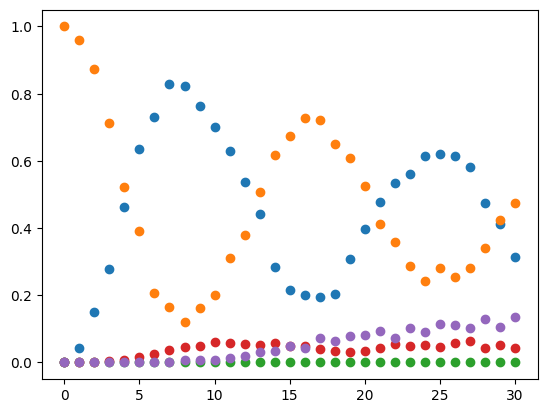

In [23]:
rhopl0=[]
rhopl1=[]
rhopl2=[]
rhopl3=[]
rhopls=[]
import matplotlib.pyplot as plt
for j in range(7):
    for i in range(len(rho0)):
        if i%7==j:
            rhopl0.append(rho0[i])
            rhopl1.append(rho1[i])
            rhopl2.append(rho2[i])
            rhopl3.append(rho3[i])
            rhopls.append(rhos[i])
print(np.shape(rhopl2[4:]))
plt.plot(rhopl2[4:],marker='o',linestyle='')
plt.plot(rhopl1[4:],marker='o',linestyle='')
plt.plot(rhopl0[4:],marker='o',linestyle='')
plt.plot(rhopl3[4:],marker='o',linestyle='')
plt.plot(rhopls[4:],marker='o',linestyle='')